In [1]:
from taxcalc import *
import copy
import numpy as np
import pandas as pd
from bokeh.plotting import show, output_file, figure
from bokeh.charts import Scatter, Bar
from bokeh.io import output_notebook
from bokeh.layouts import column
import matplotlib
%matplotlib inline
output_notebook()

Loading BokehJS ...

In [2]:
in_millions = 1.0e-6
in_billions = 1.0e-9

In [3]:
income_bins = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

In [4]:
cps = pd.read_csv('/Users/andersonfrailey/Dropbox/cpsrets_age_fix.csv', index_col=None)
cps['s006'] = cps['WT']
cps['tot_benefits'] = (cps['MedicareX'] + cps['MEDICAID'] + cps['SSI'] + cps['SNAP'] + cps['SS'] + cps['VB'])
cps['dist_benefits'] = (cps['MEDICAID'] + cps['SSI'] + cps['SNAP'] + cps['VB'])
# cps['cumsum'] = np.cumsum(cps['s006'].values)
cps = utils.add_weighted_income_bins(cps, income_measure='WAS')

In [5]:
cps_dist = pd.DataFrame(cps.groupby('bins', as_index=False).apply(utils.weighted_sum, 'dist_benefits'))
cps_dist.index = [x for x in range(1, 11)]
cps_dist.columns = ['benefits']
cps_dist['dist'] = cps_dist['benefits'] / cps_dist['benefits'].sum()
cps_dist

,benefits,dist
1,1.004559e+11,0.144557
2,1.042124e+11,0.149962
3,1.366965e+11,0.196707
4,7.809446e+10,0.112378
5,6.591905e+10,0.094858
6,5.931681e+10,0.085357
7,4.645551e+10,0.066850
8,4.216865e+10,0.060681
9,3.234310e+10,0.046542
10,2.926183e+10,0.042108


In [6]:
# Other benefits
other = pd.read_csv('benefitprograms.csv')
other['Cost'] *= 1000000
other_dist = pd.DataFrame(cps_dist['dist'] * other['Cost'].sum())

In [7]:
cps_grouped = pd.DataFrame(cps.groupby('bins', as_index=False).apply(utils.weighted_mean, 'tot_benefits'))

In [8]:
cps_sums = pd.DataFrame(cps.groupby('bins', as_index=False).apply(utils.weighted_sum, 'tot_benefits'))
cps_sums.index = [x for x in range(1,11)]

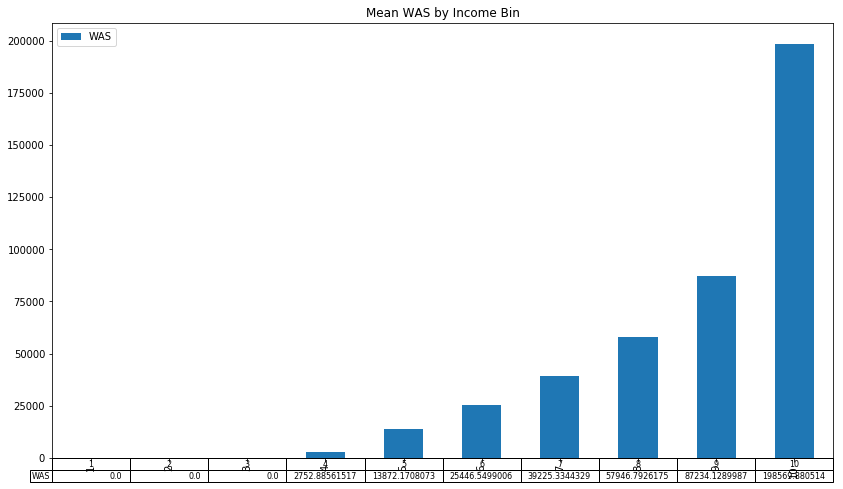

In [9]:
# Mean wage in each income bin
cps_was = pd.DataFrame(cps.groupby('bins', as_index=False).apply(utils.weighted_mean, 'WAS'))
cps_was.index = [x for x in range(1, 11)]
cps_was.columns = ['WAS']
cps_was.plot(kind='bar', figsize=(14,8), title='Mean WAS by Income Bin', table=True)

In [10]:
benefits = {'SSI': [], 'SNAP': [], 'SS': [], 'VB': [], 'MEDICAID': [], 'MedicareX': []}
for i in range(1, 11):
    for item in benefits.keys():
        pct = (cps.s006[(cps[item] > 0) & (cps['bins'] == i)].sum() / cps.s006[cps['bins'] == i].sum())
        benefits[item].append(pct)
benefits = pd.DataFrame.from_dict(benefits)
benefits.index = [x for x in range(1, 11)]

In [11]:
fig = figure(title='Participation Rates by Bin')
colors = ['red', 'blue', 'orange', 'green', 'purple', 'pink']
i = 0
for item in benefits.columns:
    fig.line(benefits.index, benefits[item], legend=item, color=colors[i], line_width=2)
    i += 1
fig.legend.location = 'top_right'
fig.legend.orientation = 'vertical'
show(fig)

In [12]:
means = {'SSI': [], 'SNAP': [], 'SS': [], 'VB': [], 'MEDICAID': [], 'MedicareX': []}
for i in range(1, 11):
    for item in benefits.keys():
        pct = ((cps[item][(cps[item] > 0) & (cps['bins'] == i)] *
                cps['s006'][(cps[item] > 0) & (cps['bins'] == i)]).sum() / (cps.s006[(cps['bins'] == i) &
                                                                                     (cps[item] > 0) &
                                                                                     (cps['bins'] == i)]).sum())
        means[item].append(pct)
means = pd.DataFrame.from_dict(means)
means.index = [x for x in range(1, 11)]

fig = figure(title='Average Benefit by Bin - Participants')
colors = ['red', 'blue', 'orange', 'green', 'purple', 'pink']
i = 0
for item in means.columns:
    fig.line(means.index, means[item], legend=item, color=colors[i], line_width=2)
    i += 1
fig.legend.location = 'top_center'
fig.legend.orientation = 'horizontal'
show(fig)

Participation Rates of Each Program

In [13]:
benefits

,MEDICAID,MedicareX,SNAP,SS,SSI,VB
1,0.322196,0.477723,0.197366,0.544161,0.057609,0.040461
2,0.315472,0.467863,0.164672,0.521660,0.052930,0.052478
3,0.354363,0.491572,0.203923,0.549554,0.068377,0.044678
4,0.311428,0.145897,0.153194,0.178802,0.033580,0.017959
5,0.309929,0.120512,0.199110,0.154093,0.023237,0.011877
6,0.225272,0.104731,0.105339,0.134017,0.021953,0.018189
7,0.186160,0.106271,0.065376,0.138342,0.022833,0.016664
8,0.162210,0.101229,0.042260,0.134552,0.014739,0.017319
9,0.132768,0.080390,0.027860,0.101976,0.013450,0.018711
10,0.102360,0.071498,0.015544,0.099007,0.006378,0.019453


In [14]:
cps_grouped['bin'] = cps_grouped.index
cps_grouped.columns = ['benefits', 'bin']

In [15]:
cps_sums['bin'] = cps_sums.index
cps_sums.columns = ['benefits', 'bin']
cps_sums['benefits'] = cps_sums['benefits']
cps_sums_bar = Bar(cps_sums, 'bin', 'benefits', agg='sum', legend=None,
                   title='Total Benefits - Billions')
show(cps_sums_bar)

In [16]:
cps_bar = Bar(cps_grouped, 'bin', 'benefits', agg='mean', legend=None,
              title='Average Total Benefits')
show(cps_bar)

In [17]:
cps_ss = pd.DataFrame(cps.groupby('bins').apply(utils.weighted_mean, 'SS'))
cps_ss['bin'] = cps_ss.index
cps_ss.columns = ['benefits', 'bin']
cps_bar_ss = Bar(cps_ss, 'bin', 'benefits', agg='mean', legend=None,
                 title='Social Security')
show(cps_bar_ss)

In [18]:
cps_ssi = pd.DataFrame(cps.groupby('bins').apply(utils.weighted_mean, 'SSI'))
cps_ssi['bin'] = cps_ssi.index
cps_ssi.columns = ['benefits', 'bin']
cps_bar_ssi = Bar(cps_ssi, 'bin', 'benefits', agg='mean', legend=None,
                 title='SSI')
show(cps_bar_ssi)

In [19]:
cps_snap = pd.DataFrame(cps.groupby('bins').apply(utils.weighted_mean, 'SNAP'))
cps_snap['bin'] = cps_snap.index
cps_snap.columns = ['benefits', 'bin']
cps_bar_snap = Bar(cps_snap, 'bin', 'benefits', agg='mean', legend=None,
                 title='SNAP')
show(cps_bar_snap)

In [20]:
cps_vb = pd.DataFrame(cps.groupby('bins').apply(utils.weighted_mean, 'VB'))
cps_vb['bin'] = cps_vb.index
cps_vb.columns = ['benefits', 'bin']
cps_bar_vb = Bar(cps_vb, 'bin', 'benefits', agg='mean', legend=None,
                 title='VB')
show(cps_bar_vb)

In [21]:
cps_care = pd.DataFrame(cps.groupby('bins').apply(utils.weighted_mean, 'MedicareX'))
cps_care['bin'] = cps_care.index
cps_care.columns = ['benefits', 'bin']
cps_bar_care = Bar(cps_care, 'bin', 'benefits', agg='mean', legend=None,
                 title='Medicare')
show(cps_bar_care)

In [22]:
cps_caid = pd.DataFrame(cps.groupby('bins').apply(utils.weighted_mean, 'MEDICAID'))
cps_caid['bin'] = cps_caid.index
cps_caid.columns = ['benefits', 'bin']
cps_bar_caid = Bar(cps_snap, 'bin', 'benefits', agg='mean', legend=None,
                 title='Medicaid')
show(cps_bar_caid)

In [23]:
recs = Records('puf_benefits.csv', weights='puf_weights_new.csv', adjust_ratios='puf_ratios copy.csv')
pol = Policy()
calc = Calculator(records=recs, policy=pol, verbose=False)
calc.advance_to_year(2014)
calc.calc_all()

In [24]:
recs2 = Records('puf_benefits.csv', weights='puf_weights_new.csv', adjust_ratios='puf_ratios copy.csv')
pol2 = Policy()
tax_reform = {
    2014: {
        '_ALD_StudentLoan_hc': [1.0],
        '_ALD_SelfEmploymentTax_hc': [1.0],
        '_ALD_SelfEmp_HealthIns_hc': [1.0],
        '_ALD_KEOGH_SEP_hc': [1.0],
        '_ALD_EarlyWithdraw_hc': [1.0],
        '_ALD_Alimony_hc': [1.0],
        '_ALD_Dependents_hc': [1.0],
        '_ALD_EducatorExpenses_hc': [1.0],
        '_ALD_HSADeduction_hc': [1.0],
        '_ALD_IRAContributions_hc': [1.0],
        '_ALD_DomesticProduction_hc': [1.0],
        '_ALD_Tuition_hc': [1.0],
        '_CR_RetirementSavings_hc': [1.0],
        '_CR_ForeignTax_hc': [1.0],
        '_CR_ResidentialEnergy_hc': [1.0],
        '_CR_GeneralBusiness_hc': [1.0],
        '_CR_MinimumTax_hc': [1.0],
        '_CR_AmOppRefundable_hc': [1.0],
        '_CR_AmOppNonRefundable_hc': [1.0],
        '_CR_SchR_hc': [1.0],
        '_CR_OtherCredits_hc': [1.0],
        '_CR_Education_hc': [1.0],
        '_II_em': [0.0],
        '_STD': [[0.0, 0.0, 0.0, 0.0, 0.0]],
        '_STD_Aged': [[0.0, 0.0, 0.0, 0.0, 0.0]],
        '_ID_Medical_hc': [1.0],
        '_ID_StateLocalTax_hc': [1.0],
        '_ID_RealEstate_hc': [1.0],
        '_ID_InterestPaid_hc': [1.0],
        '_ID_Casualty_hc': [1.0],
        '_ID_Miscellaneous_hc': [1.0],
        '_CDCC_c': [0.0],
        '_CTC_c': [0.0],
        '_EITC_c': [[0.0, 0.0, 0.0, 0.0]],
        '_LLC_Expense_c': [0.0],
        '_ETC_pe_Single': [0.0],
        '_ETC_pe_Married': [0.0],
    }
}
pol2.implement_reform(tax_reform)
calc2 = Calculator(records=recs2, policy=pol2, verbose=False)
calc2.records.e02400 = np.zeros(len(calc2.records.e02400))
calc2.advance_to_year(2014)
calc2.calc_all()

In [25]:
mtr = calc2.mtr()
imtr = mtr[1]
print 'Min MTR where AGI < 0:', min(imtr[calc2.records.c00100 < 0])
print 'Max MTR where AGI < 0:', max(imtr[calc2.records.c00100 < 0])
print 'Avg MTR where AGI < 0:', imtr[calc2.records.c00100 < 0].mean()

Min MTR where AGI < 0: -1.35178032776e-09
Max MTR where AGI < 0: 0.344997544946
Avg MTR where AGI < 0: 0.0138616128712


In [26]:
primary_ii = utils.xtr_graph_plot(utils.mtr_graph_data(calc, calc2, mtr_measure='itax'))
primary_fica = utils.xtr_graph_plot(utils.mtr_graph_data(calc, calc2, mtr_measure='ptax'))
secondary_ii = utils.xtr_graph_plot(utils.mtr_graph_data(calc, calc2, mars=2,
                                                         mtr_measure='itax', mtr_variable='e00200s'))
secondary_fica = utils.xtr_graph_plot(utils.mtr_graph_data(calc, calc2, mars=2,
                                                           mtr_measure='ptax', mtr_variable='e00200s'))

In [27]:
show(column(primary_ii, secondary_ii))
show(column(primary_fica, secondary_fica))

In [28]:
# New tax liability
tax_gain = ((calc2.records._combined - calc.records._combined) * calc2.records.s006).sum()

In [29]:
tax_gain

649741603000.2979

In [30]:
nu18 = (calc2.records.nu18 * calc2.records.s006).sum()
n1821 = (calc2.records.n1821 * calc2.records.s006).sum()
n21 = (calc2.records.n21 * calc2.records.s006).sum()

In [31]:
def ubi(rev):
    ubi_18 = revenue / ((nu18 * 0.5) + n1821 + n21)
    ubi_u18 = ubi_18 * 0.5
    return ubi_18, ubi_u18

In [32]:
# Total benefits repealed
cps_b = pd.read_csv('/Users/andersonfrailey/Dropbox/cpsrets_age_fix.csv', index_col=None)
cps_b['s006'] = cps_b['WT']
cps_b['tot_benefits'] = (cps_b['MedicareX'] + cps_b['MEDICAID'] + cps_b['SSI'] +
                         cps_b['SNAP'] + cps_b['SS'] + cps['VB'])
cps_b['no_ss'] = (cps_b['MedicareX'] + cps_b['MEDICAID'] + cps_b['SSI'] +
                  cps_b['SNAP'] + cps['VB'])
ben_rev = (cps_b['tot_benefits'] * cps_b['s006']).sum()

In [33]:
recs_ss = Records('puf_benefits.csv', weights='puf_weights_new.csv', adjust_ratios='puf_ratios copy.csv')
calc_ss = Calculator(records=recs_ss, policy=Policy(), verbose=False)
calc_ss.records.e02400 = np.zeros(len(calc_ss.records.e02400))
calc_ss.advance_to_year(2014)
calc_ss.calc_all()

In [34]:
# Loss in taxes from SS repeal
loss = ((calc_ss.records._combined - calc.records._combined) * calc_ss.records.s006).sum()
loss

-43255265714.60136

In [35]:
revenue = ben_rev + loss + tax_gain + other_dist['dist'].sum()
revenue

3145908011172.4185

### UBI

In [36]:
ubi18, ubiu18 = ubi(revenue)
ubi18, ubiu18

(10852.023406388838, 5426.011703194419)

In [37]:
recs_ubi = Records('puf_benefits.csv', weights='puf_weights_new.csv', adjust_ratios='puf_ratios copy.csv')
pol_ubi = Policy()
pol_ubi.implement_reform(tax_reform)
ubi_ref = {
    2014: {
        '_UBI1': [ubiu18],
        '_UBI2': [ubi18],
        '_UBI3': [ubi18]
    }
}
pol_ubi.implement_reform(ubi_ref)
calc_ubi = Calculator(records=recs_ubi, policy=pol_ubi, verbose=False)
calc_ubi.advance_to_year(2014)
calc_ubi.calc_all()

In [38]:
mtr_ubi = calc_ubi.mtr()
imtr_ubi = mtr_ubi[1]

In [39]:
print 'Min MTR where AGI < 0:', min(imtr_ubi[calc_ubi.records.c00100 < 0])
print 'Max MTR where AGI < 0:', max(imtr_ubi[calc_ubi.records.c00100 < 0])
print 'Avg MTR where AGI < 0:', imtr_ubi[calc_ubi.records.c00100 < 0].mean()

Min MTR where AGI < 0: -1.35178032776e-09
Max MTR where AGI < 0: 0.344997537774
Avg MTR where AGI < 0: 0.0169965374265


In [40]:
primary_ubi = utils.xtr_graph_plot(utils.mtr_graph_data(calc, calc_ubi, mtr_measure='itax'))
show(primary_ubi)

In [41]:
net_gains = pd.DataFrame()
net_gains['ubi'] = copy.deepcopy(calc_ubi.records.ubi)
net_gains['taxes'] = copy.deepcopy(calc.records._combined - calc_ubi.records._combined)
net_gains['s006'] = copy.deepcopy(calc_ubi.records.s006)
net_gains['_expanded_income'] = copy.deepcopy(calc_ubi.records._expanded_income)
net_gains['net'] = net_gains['ubi'] + net_gains['taxes']

In [42]:
net_gains = utils.add_weighted_income_bins(net_gains, income_measure='_expanded_income')
net_gains_grouped = pd.DataFrame(net_gains.groupby('bins').apply(utils.weighted_sum, 'net'))

In [43]:
net_gains_grouped['bin'] = net_gains_grouped.index
net_gains_grouped.columns = ['net gain', 'bin']
net_gains_grouped['net gain'] = net_gains_grouped['net gain']

In [44]:
show(Bar(net_gains_grouped, 'bin', 'net gain', legend=None,
         title='Net Gain: UBI - Taxes'))

In [45]:
net_ben = pd.DataFrame()
net_ben['net gain'] = copy.deepcopy(net_gains_grouped['net gain'])
net_ben['cps'] = copy.deepcopy(cps_sums['benefits'])
net_ben['net'] = net_ben['net gain'] - net_ben['cps'] - other_dist['dist']
net_ben['type'] = 'Dollar Values'
net_ben['bin'] = net_ben.index

In [46]:
# Welfare multiples
welfare_mult ={
    'mcare': 0.75,
    'mcaid': 0.30,
    'snap': 0.95,
    'ss': 0.95,
    'ssi': 0.95,
    'vb': 0.95
}

In [47]:
cps_b['adj_benefit'] = ((cps_b['MedicareX'] * welfare_mult['mcare']) +
                        (cps_b['MEDICAID'] * welfare_mult['mcaid']) +
                        (cps_b['SSI'] * welfare_mult['ssi']) +
                        (cps_b['SNAP'] * welfare_mult['snap']) +
                        (cps_b['SS'] * welfare_mult['ss']) +
                        (cps_b['VB'] * welfare_mult['vb']))
cps_b['no_ss_adj']  = ((cps_b['MedicareX'] * welfare_mult['mcare']) +
                       (cps_b['MEDICAID'] * welfare_mult['mcaid']) +
                       (cps_b['SSI'] * welfare_mult['ssi']) +
                       (cps_b['SNAP'] * welfare_mult['snap']) +
                       (cps_b['VB'] * welfare_mult['vb']))
cps_b = utils.add_weighted_income_bins(cps_b, income_measure='WAS')
cps_bg = pd.DataFrame(cps_b.groupby('bins', as_index=False).apply(utils.weighted_sum, 'adj_benefit'))
cps_bg.index = [x for x in range(1, 11)]
cps_bg['bin'] = cps_bg.index
cps_bg.columns = ['benefits', 'bin']

In [48]:
net_welfare = pd.DataFrame()
net_welfare['net gain'] = copy.deepcopy(net_gains_grouped['net gain'])
net_welfare['cps'] = copy.deepcopy(cps_bg['benefits'])
net_welfare['net'] = net_welfare['net gain'] - net_welfare['cps'] - other_dist['dist']
net_welfare['type'] = 'Multilpliers'
net_welfare['bin'] = net_welfare.index

In [49]:
net_graphable = pd.concat([net_ben, net_welfare])

In [50]:
show(Bar(net_graphable, 'bin', 'net', agg='sum', group='type',
         title='UBI Benefits - Taxes - Welfare Benefit Loss'))

### Just units with no one over 65

In [51]:
net_gains_u65 = pd.DataFrame()
net_gains_u65['ubi'] = copy.deepcopy(calc_ubi.records.ubi[calc.records.e02400 == 0])
net_gains_u65['taxes'] = copy.deepcopy(calc.records._combined[calc.records.e02400 == 0] -
                                       calc_ubi.records._combined[calc.records.e02400 == 0])
s006 = copy.deepcopy(calc_ubi.records.s006[calc.records.e02400 == 0].values)
net_gains_u65['s006'] = s006
net_gains_u65['c00100'] = copy.deepcopy(calc_ubi.records.c00100[calc.records.e02400 == 0])
net_gains_u65['net'] = net_gains_u65['ubi'] + net_gains_u65['taxes']

In [52]:
ng_u65 = utils.add_weighted_income_bins(net_gains_u65, income_measure='c00100')
net_gains_grouped_u65 = pd.DataFrame(ng_u65.groupby('bins').apply(utils.weighted_sum, 'net'))

In [53]:
net_gains_grouped_u65['bin'] = net_gains_grouped.index
net_gains_grouped_u65.columns = ['net gain', 'bin']

In [54]:
show(Bar(net_gains_grouped_u65, 'bin', 'net gain', legend=None,
         title='Net Gain: UBI - Taxes'))

In [55]:
# Split total beneft loss 
prop = net_gains_u65['s006'].sum() / calc_ubi.records.s006.sum()

In [56]:
cps_bs = pd.DataFrame(cps_b.groupby('bins', as_index=False).apply(utils.weighted_sum, 'no_ss'))
cps_bs.index = [x for x in range(1, 11)]
cps_bs.columns = ['benefits']

In [57]:
# Dollar Value Net Benefits
net_u65 = pd.DataFrame()
net_u65['net gain'] = copy.deepcopy(net_gains_grouped_u65['net gain'])
net_u65['cps'] = cps_bs['benefits'] * prop
net_u65['type'] = 'Dollar Value'
net_u65['net'] = net_u65['net gain'] - net_u65['cps'] - (other_dist['dist'] * prop)
net_u65['bin'] = net_u65.index

In [58]:
cps_bs_adj = pd.DataFrame(cps_b.groupby('bins', as_index=False).apply(utils.weighted_sum, 'no_ss_adj'))
cps_bs_adj.index = [x for x in range(1, 11)]
cps_bs_adj.columns = ['benefits']

# Adjusted Value benefits
net_u65adj = pd.DataFrame()
net_u65adj['net gain'] = copy.deepcopy(net_gains_grouped_u65['net gain'])
net_u65adj['cps'] = copy.deepcopy(cps_bs_adj['benefits']) * prop
net_u65adj['type'] = 'Multiples'
net_u65adj['net'] = net_u65adj['net gain'] - net_u65adj['cps'] - (other_dist['dist'] * prop)
net_u65adj['bin'] = net_u65adj.index

In [59]:
netu65_graph = pd.concat([net_u65, net_u65adj])

In [60]:
no65_graph = Bar(netu65_graph, 'bin', 'net', group='type',
                 title='UBI - New Taxes - Benefit Loss - Those under 65')
no65_graph.legend.location='top_right'
show(no65_graph)

### Just units with someone over 65

In [61]:
net_gains_65 = pd.DataFrame()
net_gains_65['ubi'] = copy.deepcopy(calc_ubi.records.ubi[calc.records.e02400 > 0])
net_gains_65['taxes'] = copy.deepcopy(calc.records._combined[calc.records.e02400 > 0] -
                                      calc_ubi.records._combined[calc.records.e02400 > 0])
s00665 = copy.deepcopy(calc_ubi.records.s006[calc.records.e02400 > 0].values)
net_gains_65['s006'] = s00665
net_gains_65['c00100'] = copy.deepcopy(calc_ubi.records.c00100[calc.records.e02400 > 0])
net_gains_65['net'] = net_gains_65['ubi'] + net_gains_65['taxes']

In [62]:
ng_65 = utils.add_weighted_income_bins(net_gains_65, income_measure='c00100')
net_gains_grouped_65 = pd.DataFrame(ng_65.groupby('bins').apply(utils.weighted_sum, 'net'))

In [63]:
net_gains_grouped_65['bin'] = net_gains_grouped_65.index
net_gains_grouped_65.columns = ['net gain', 'bin']

In [64]:
show(Bar(net_gains_grouped_65, 'bin', 'net gain', legend=None,
         title='Net Gain: UBI - Taxes'))

In [65]:
prop65 = net_gains_65['s006'].sum() / calc_ubi.records.s006.sum()

In [66]:
cps_b['ss'] = (cps_b['no_ss'] * prop65) + cps_b['SS']
cps_b['ss_adj'] = (cps_b['no_ss_adj'] * prop65) + (cps_b['SS'] * welfare_mult['ss'])

In [67]:
cps_bs65 = pd.DataFrame(cps_b.groupby('bins', as_index=False).apply(utils.weighted_sum, 'ss'))
cps_bs65.index = [x for x in range(1, 11)]
cps_bs65.columns = ['benefits']

In [68]:
# Dollar Value Net Benefits
net_65 = pd.DataFrame()
net_65['net gain'] = copy.deepcopy(net_gains_grouped_65['net gain'])
net_65['cps'] = cps_bs['benefits'] * prop
net_65['type'] = 'Dollar Value'
net_65['net'] = net_65['net gain'] - net_65['cps'] - (other_dist['dist'] * prop)
net_65['bin'] = net_65.index

In [69]:
cps_bs_adj65 = pd.DataFrame(cps_b.groupby('bins', as_index=False).apply(utils.weighted_sum, 'ss_adj'))
cps_bs_adj65.index = [x for x in range(1, 11)]
cps_bs_adj65.columns = ['benefits']

# Adjusted Value benefits
net_65adj = pd.DataFrame()
net_65adj['net gain'] = copy.deepcopy(net_gains_grouped_65['net gain'])
net_65adj['cps'] = copy.deepcopy(cps_bs_adj['benefits']) * prop
net_65adj['type'] = 'Multiples'
net_65adj['net'] = net_65adj['net gain'] - net_65adj['cps'] - (other_dist['dist'] * prop)
net_65adj['bin'] = net_65adj.index

In [70]:
net65_graph = pd.concat([net_65, net_65adj])

In [71]:
only65_graph = Bar(net65_graph, 'bin', 'net', group='type',
                   title='UBI - New Taxes - Benefit Loss - Those under 65')
only65_graph.legend.location='top_right'
show(only65_graph)